In [1]:
import os
import pandas as pd
import random

import sys

sys.path.insert(0, "..")

from unpast.run_unpast import unpast
from unpast.core.preprocessing import prepare_input_matrix
from unpast.misc.consensus import make_consensus_biclusters

### Input and output

This example uses expressions of 200 randomly chosen samples from the TCGA-BRCA dataset (normalized and standardized log2(x+1) RNA-seq counts)

In [2]:
!pip install gdown


[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [3]:
# input .tsv file; features in rows, samples in columns
exprs_file = "test_data_TCGA200/TCGA_200.exprs_z.tsv"

if not os.path.exists(exprs_file):
    from gdown import download
    from zipfile import ZipFile

    url = "https://drive.google.com/uc?id=1zee_GssqXCv_-tokLRJKR8cLksxsa8UN"
    output = "TCGA200_example.zip"
    download(url, output, quiet=False)

    with ZipFile(output, "r") as zip_ref:
        zip_ref.extractall()
    os.remove(output)
# or download and unzip it manually: https://drive.google.com/file/d/1zee_GssqXCv_-tokLRJKR8cLksxsa8UN/view?usp=drive_link# input .tsv file; features in rows, samples in columns

Downloading...
From (original): https://drive.google.com/uc?id=1zee_GssqXCv_-tokLRJKR8cLksxsa8UN
From (redirected): https://drive.google.com/uc?id=1zee_GssqXCv_-tokLRJKR8cLksxsa8UN&confirm=t&uuid=c6f7df24-671f-4988-9014-df7b914be3ac
To: /home/olga/UHH/UnPaSt/unpast/notebooks/TCGA200_example.zip
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 26.8M/26.8M [00:01<00:00, 24.3MB/s]


In [4]:
# specify output folder and output file prefix
basename = "TCGA200"
out_dir = "TCGA200_example/"

### Run UnPaSt 

In [5]:
results = unpast(exprs_file, basename, out_dir=out_dir, seed=42)

In [6]:
results.head(2)

SNR n_genes n_samples  \
0  3.528302      39        37   
1  2.453225     157        38   

                                               genes  \
0  {CMBL, LINC00940, CA8, SPDEF, C1orf64, LRFN2, ...   
1  {GSTA2, STRA8, PRSS41, RP11-351J23.1, KRT9, PS...   

                                             samples direction  \
0  {TCGA-C8-A12V-01, TCGA-A2-A04Q-01, TCGA-C8-A27...      DOWN   
1  {TCGA-C8-A12V-01, TCGA-A2-A04Q-01, TCGA-C8-A27...        UP   

                                            genes_up  \
0                                                 {}   
1  {GSTA2, STRA8, PRSS41, RP11-351J23.1, KRT9, PS...   

                                          genes_down  \
0  {CMBL, LINC00940, CA8, SPDEF, LRFN2, MLPH, SLC...   
1                                                 {}   

                                        gene_indexes  \
0  {1923, 388, 9990, 3847, 7176, 11795, 11159, 38...   
1  {7681, 9729, 12290, 3077, 1035, 7695, 1553, 20...   

                                      sample_indexes  
0  {128, 2, 131, 4, 7, 136, 139, 12, 13, 145, 19,...  
1  {128, 2, 131, 4, 7, 136, 139, 12, 13, 145, 19,...

### Re-run UnPaSt using previously computed binarization results

add `load = True`

In [7]:
results2 = unpast(
    exprs_file,
    basename,
    out_dir=out_dir,
    load=True,  # try loading precomputed binarization results
    seed=42,
)

### Read and write UnPaSt results

In [8]:
from unpast.utils.io import write_bic_table, read_bic_table

In [9]:
suffix = ".bin=kmeans,pval=0.01,clust=WGCNA,direction=DOWN-UP,ds=3,dch=0.995,max_power=10,precluster=True"
seed = 42
bic_file = out_dir + "/" + basename + ".seed=" + str(seed) + suffix + ".biclusters.tsv"
biclusters = read_bic_table(bic_file)
biclusters.head(2)

SNR  n_genes  n_samples  \
id                                 
0   3.528302       39         37   
1   2.453225      157         38   

                                                genes  \
id                                                      
0   {CMBL, LINC00940, CA8, SPDEF, C1orf64, LRFN2, ...   
1   {GSTA2, STRA8, PRSS41, RP11-351J23.1, KRT9, PS...   

                                              samples direction  \
id                                                                
0   {TCGA-C8-A12V-01, TCGA-A2-A04Q-01, TCGA-C8-A27...      DOWN   
1   {TCGA-C8-A12V-01, TCGA-A2-A04Q-01, TCGA-C8-A27...        UP   

                                             genes_up  \
id                                                      
0                                                  {}   
1   {GSTA2, STRA8, PRSS41, RP11-351J23.1, KRT9, PS...   

                                           genes_down  \
id                                                      
0   {CMBL, LINC00940, CA8, SPDEF, C1orf64, LRFN2, ...   
1                                                  {}   

                                         gene_indexes  \
id                                                      
0   {1923, 388, 9990, 3847, 7176, 11795, 11159, 38...   
1   {9729, 7681, 12290, 3077, 1035, 7695, 1553, 20...   

                                       sample_indexes  
id                                                     
0   {128, 2, 131, 4, 7, 136, 139, 12, 13, 145, 19,...  
1   {128, 2, 131, 4, 7, 136, 139, 12, 13, 145, 19,...

In [10]:
new_file_name = "TCGA200_example/TCGA200.biclusters.tsv"
write_bic_table(biclusters, new_file_name)

# Consensus biclusters from 5 runs

#### 1. Running UnPaSt five times with different seeds

* biclusters from individual runs:

\<basename>.seed=\<seed>.bin=kmeans,pval=0.01,clust=WGCNA,direction=DOWN-UP,ds=3,dch=0.995,max_power=10,precluster=True.biclusters.tsv


In [11]:
n_runs = 5
analysis_seed = 0
random.seed(analysis_seed)
seeds = []
for i in range(n_runs):
    seeds.append(random.randint(0, 1000000))
print("generate ", n_runs, " seeds", seeds)

generate  5  seeds [885440, 403958, 794772, 933488, 441001]


In [12]:
biclusters = []
for seed in seeds:
    results = unpast(exprs_file, basename, out_dir=out_dir, load=False, seed=seed)
    # make bicluster ids unique: 'seed=<seed>_<bicluster id>'
    results.index = ["seed=" + str(seed) + "_" + str(x) for x in results.index.values]
    biclusters.append(results)
    print("seed = %s\tn_biclusters: %s" % (seed, results.shape[0]))

seed = 885440	n_biclusters: 117
seed = 403958	n_biclusters: 146
seed = 794772	n_biclusters: 135
seed = 933488	n_biclusters: 118
seed = 441001	n_biclusters: 124


#### 2. Combine the results of five independent runs to consensus biclusters

* consensus biclusters:

TCGA200.consensus_seed=0.bin=kmeans,pval=0.01,clust=WGCNA,direction=DOWN-UP,ds=3,dch=0.995,max_power=10,precluster=True.biclusters.tsv


In [13]:
exprs = pd.read_csv(exprs_file, sep="\t", index_col=0)

# filter and z-score transform input matrix, limit z-scores to [-3,3]
exprs_z = prepare_input_matrix(exprs, min_n_samples=5, ceiling=3)
consensus_biclusters = make_consensus_biclusters(
    biclusters, exprs_z, seed=analysis_seed, verbose=True, plot=False
)

consensus_biclusters.head(3)

9 s for similarity matrix
	Running Louvain ...
		modularity: newman


sknetwork version used: 0.33.0


	curve type: increasing
	Louvain runtime: modules detected in 0.53 s.
	modules: 141, not clustered features 74 
		similarity cutoff: 0.43 modularity: 0.991
keep genes included in at least 2 merged biclusters
all consensus biclusters: 220
detected 2+ times:136
2 s for making consensus biclusters from consensus gene sets


SNR n_genes n_samples  \
0  2.922866     155        36   
1  2.763514       2        14   
2  2.674523       7        24   

                                               genes  \
0  {GSTA2, STRA8, PRSS41, RP11-351J23.1, KLHDC3, ...   
1                               {LUC7L2, ISY1-RAB43}   
2       {TLX3, IGSF23, DMRT1, NCAN, EN1, KRT9, PAPL}   

                                             samples  \
0  {TCGA-C8-A12V-01, TCGA-A2-A04Q-01, TCGA-C8-A27...   
1  {TCGA-AO-A1KR-01, TCGA-AN-A0FT-01, TCGA-A7-A56...   
2  {TCGA-EW-A1P7-01, TCGA-A2-A0D0-01, TCGA-BH-A0E...   

                                            genes_up  \
0  {GSTA2, STRA8, PRSS41, RP11-351J23.1, KLHDC3, ...   
1                                                 {}   
2       {TLX3, IGSF23, DMRT1, NCAN, EN1, KRT9, PAPL}   

                                          genes_down  \
0  {SPDEF, LRFN2, MLPH, SLC44A4, XBP1, AGR2, PRR1...   
1                               {LUC7L2, ISY1-RAB43}   
2                                                 {}   

                                        gene_indexes  \
0  {9729, 12290, 3077, 1553, 11795, 2068, 6677, 1...   
1                                       {6282, 7263}   
2        {6080, 8261, 12997, 6792, 4019, 9012, 3546}   

                                      sample_indexes direction  \
0  {128, 2, 131, 4, 7, 136, 139, 12, 13, 145, 19,...      BOTH   
1  {193, 69, 70, 166, 168, 110, 19, 52, 179, 86, ...      DOWN   
2  {131, 7, 139, 12, 13, 145, 19, 147, 157, 36, 1...        UP   

   detected_n_times                                                ids  
0                 7  {seed=933488_3, seed=403958_0, seed=441001_2, ...  
1                 2                    {seed=885440_26, seed=933488_1}  
2                 7  {seed=403958_12, seed=794772_7, seed=885440_6,...

### Examples of biclusters with known BRCA subtype biomerkers 

In [14]:
g = "ERBB2"
b = consensus_biclusters
b[b["genes"].apply(lambda x: g in x)]

SNR n_genes n_samples  \
34  1.708024      15        20   

                                                genes  \
34  {SOHLH1, SERHL2, NEU4, ERBB2, PGAP3, STARD3, Z...   

                                              samples  \
34  {TCGA-AC-A23C-01, TCGA-LD-A9QF-01, TCGA-A8-A07...   

                                             genes_up genes_down  \
34  {SOHLH1, SERHL2, NEU4, PGAP3, ZP2, STARD3, NXP...         {}   

                                         gene_indexes  \
34  {3552, 14946, 10075, 12074, 11338, 12875, 9294...   

                                       sample_indexes direction  \
34  {129, 132, 134, 149, 28, 29, 39, 46, 47, 54, 6...        UP   

    detected_n_times                                                ids  
34                 5  {seed=933488_14, seed=403958_16, seed=885440_1...

In [15]:
g = "ESR1"
b[b["genes"].apply(lambda x: g in x)]

SNR n_genes n_samples  \
3  2.472176     139        47   

                                               genes  \
3  {CMBL, KDM4B, SORCS1, LPPR3, MYO18B, XBP1, PKI...   

                                             samples genes_up  \
3  {TCGA-C8-A12V-01, TCGA-A2-A04Q-01, TCGA-C8-A27...       {}   

                                          genes_down  \
3  {CMBL, KDM4B, SORCS1, LPPR3, MYO18B, XBP1, PKI...   

                                        gene_indexes  \
3  {3596, 5647, 13331, 11795, 4117, 1558, 20, 719...   

                                      sample_indexes direction  \
3  {128, 2, 131, 4, 132, 134, 7, 135, 136, 139, 1...      DOWN   

   detected_n_times                                                ids  
3                 5  {seed=403958_2, seed=933488_2, seed=441001_3, ...

In [16]:
g = "FOXA1"
b[b["genes"].apply(lambda x: g in x)]

SNR n_genes n_samples  \
0  2.922866     155        36   
3  2.472176     139        47   

                                               genes  \
0  {GSTA2, STRA8, PRSS41, RP11-351J23.1, KLHDC3, ...   
3  {CMBL, KDM4B, SORCS1, LPPR3, MYO18B, XBP1, PKI...   

                                             samples  \
0  {TCGA-C8-A12V-01, TCGA-A2-A04Q-01, TCGA-C8-A27...   
3  {TCGA-C8-A12V-01, TCGA-A2-A04Q-01, TCGA-C8-A27...   

                                            genes_up  \
0  {GSTA2, STRA8, PRSS41, RP11-351J23.1, KLHDC3, ...   
3                                                 {}   

                                          genes_down  \
0  {SPDEF, LRFN2, MLPH, SLC44A4, XBP1, AGR2, PRR1...   
3  {CMBL, KDM4B, SORCS1, LPPR3, MYO18B, XBP1, PKI...   

                                        gene_indexes  \
0  {9729, 12290, 3077, 1553, 11795, 2068, 6677, 1...   
3  {3596, 5647, 13331, 11795, 4117, 1558, 20, 719...   

                                      sample_indexes direction  \
0  {128, 2, 131, 4, 7, 136, 139, 12, 13, 145, 19,...      BOTH   
3  {128, 2, 131, 4, 132, 134, 7, 135, 136, 139, 1...      DOWN   

   detected_n_times                                                ids  
0                 7  {seed=933488_3, seed=403958_0, seed=441001_2, ...  
3                 5  {seed=403958_2, seed=933488_2, seed=441001_3, ...

In [16]:
g = "SEZ6"
b = consensus_biclusters
b[b["genes"].apply(lambda x: g in x)]

SNR n_genes n_samples  \
28  1.734242      10        17   
29  1.732302       3        25   

                                                genes  \
28  {SEZ6, CARTPT, PCSK2, SYT4, AMER3, KCNH6, LRTM...   
29                               {AMER3, SEZ6, KCNH6}   

                                              samples  \
28  {TCGA-E9-A3HO-01, TCGA-E2-A15S-01, TCGA-C8-A1H...   
29  {TCGA-A8-A083-01, TCGA-AR-A0U3-01, TCGA-E2-A56...   

                                             genes_up genes_down  \
28  {SEZ6, PCSK2, CARTPT, SYT4, AMER3, KCNH6, LRTM...         {}   
29                               {AMER3, SEZ6, KCNH6}         {}   

                                         gene_indexes  \
28  {11392, 2913, 12579, 6442, 12523, 1875, 9140, ...   
29                                 {11392, 6442, 534}   

                                       sample_indexes direction  \
28  {33, 98, 35, 162, 134, 103, 168, 77, 17, 177, ...        UP   
29  {1, 130, 17, 20, 21, 150, 23, 151, 31, 33, 162...        UP   

    detected_n_times                                                ids  
28                 5  {seed=933488_13, seed=885440_9, seed=403958_8,...  
29                 3   {seed=885440_87, seed=794772_68, seed=403958_24}

### Plot heatmap for selected biclusters
* Basal: 0,lightblue
* Her2+: 34,yellow
* Neuroendocrine: 28,orange

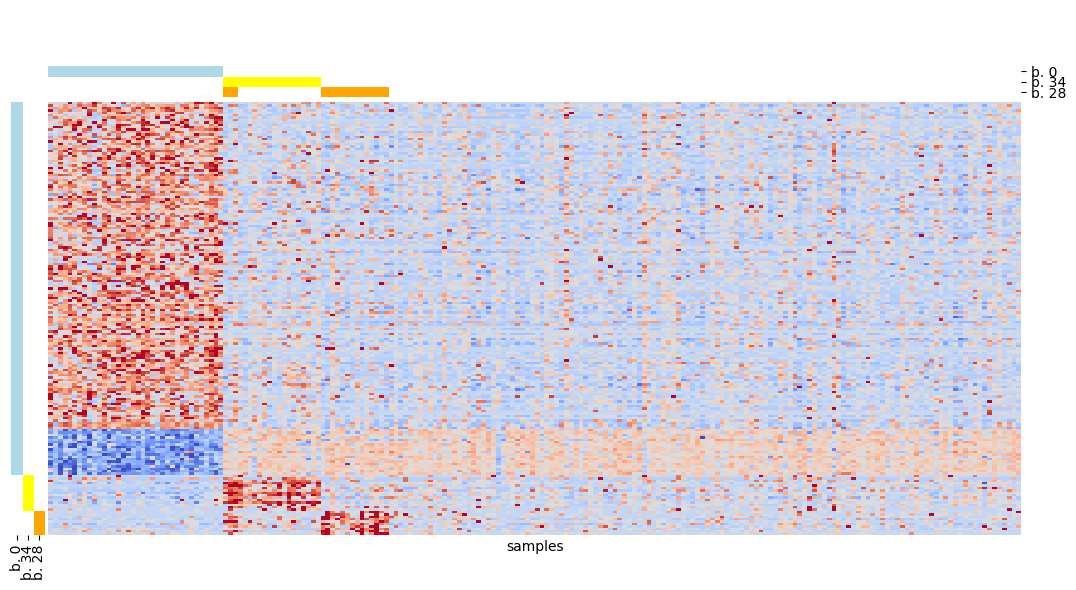

In [17]:
from unpast.utils.figs import draw_heatmap2
# from unpast.core.preprocessing import zscore

# select several biclusters to plot
# Basal: 0,lightblue; Her2+: 34,yellow; Neuroendocrine: 28,orange
i = [0, 34, 28]
b = consensus_biclusters.loc[i, :]


tmp = draw_heatmap2(
    exprs_z,
    b,
    bicluster_colors=["lightblue", "yellow", "orange"],  # "auto",
    figsize=(12, 6),
    dendrogram_ratio=(0.1, 0.1),
    colors_ratio=(0.02 / 12 * 6, 0.02),
    bic_prefix="b. ",
    no_legend=True,
    no_cbar=True,
    col_labels=False,
    row_labels=False,
    no_row_colors=False,
    cluster_rows=False,
)